### Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%208-%20Prophet%20and%20NeuralProphet/Module8_prophet_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 8: Prophet and NeuralProphet 

In this module, we explore Prophet and its extension NeuralProphet — powerful forecasting tools designed to tackle real-world business time series challenges. Developed by Facebook, Prophet is known for its ease of use, interpretability, and flexibility in modeling complex components like holidays, multiple seasonalities, and growth constraints. 

Below, we expand the scope by introducing NeuralProphet, which builds on Prophet by adding autoregressive modeling and a neural network component to capture short-term dependencies and richer dynamics.

**Readings**: 
1. Prophet: Forecasting at Scale paper: https://peerj.com/preprints/3190.pdf 
2. Prophet documentation: https://facebook.github.io/prophet/docs/quick_start.html  
3. NeuralProphet: Explainable forecasting at Scale: https://arxiv.org/abs/2111.15397  
4. NeuralProphet documentation: https://neuralprophet.com/contents.html  


## Installation

Refer to the NeuralProphet documentation for the most up-to-date installation guide:  https://neuralprophet.com/quickstart.html


In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Importing Dataset

## Airline Passenger Dataset

In [2]:
# Load the data fresh without setting index
url = "https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv"
df = pd.read_csv(url)

df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


For univariate forecasting, the input to NeuralProphet is always a dataframe with two columns: **ds** and **y**. 

- The **ds** (datestamp) column should be of a format expected by Pandas, ideally **YYYY-MM-DD** for a date or **YYYY-MM-DD HH:MM:SS** for a timestamp. 
- The y column must be numeric, and represents the measurement we wish to forecast.

🎯 Quick Rule to Remember:

Never set index_col manually when loading time series for NeuralProphet.
Instead, load the CSV normally, then create/convert ds yourself with pd.to_datetime().

In [3]:
# Manually parse the 'Month' column
df['ds'] = pd.to_datetime(df['Month'])
df['y'] = df['Passengers']

df.head()

,Month,Passengers,ds,y
0,1949-01,112,1949-01-01,112
1,1949-02,118,1949-02-01,118
2,1949-03,132,1949-03-01,132
3,1949-04,129,1949-04-01,129
4,1949-05,121,1949-05-01,121


### Preparing time series data for Prophet


In [4]:
# Keep only the necessary columns
df = df[['ds', 'y']]

# Double check
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## Setting Hypyerparameters

NeuralProphet has a number of hyperparameters that need to be specified by the user. If not specified, default values for these hyperparameters will be used. View the NeuralProphet class in the API documentation of forecaster.py for details on all hyperparameters.
- https://neuralprophet.com/how-to-guides/feature-guides/hyperparameter-selection.html
- https://github.com/ourownstory/neural_prophet/blob/main/neuralprophet/forecaster.py

| **Hyperparameter**                   | **Description** |
|--------------------------------------|-----------------|
| `n_forecasts`                        | Size of forecast horizon; default is 1, meaning one step into the future. |
| `n_lags`                             | Number of lags to include; enables AR-Net if > 0. Should generally be ≥ `n_forecasts`. |
| `learning_rate`                      | Learning rate for optimization; automatically selected if not set manually. |
| `epochs`                             | Number of training epochs; determined based on dataset size if not specified. |
| `loss_func`                          | Loss function used during training; default is `SmoothL1Loss`. |
| `optimizer`                          | Optimizer used for training; can be set to `AdamW` (default) or `SGD`. |
| `batch_size`                         | Mini-batch size for training; adjust based on overfitting/underfitting behavior. |
| `ar_layers`                          | Array specifying hidden layer sizes in AR-Net; default is empty (no hidden layers). |
| `lagged_reg_layers`                  | Array for hidden layers in lagged regressor FFNN; default is empty. |
| `normalize_y`                        | Whether to normalize target variable; default is soft min-max normalization. |
| `impute_missing`                     | Whether to impute missing values; especially needed if using AR-Net. |
| `collect_metrics`                    | Whether to compute evaluation metrics like MAE and RMSE; default is `True`. |
| `n_changepoints`                     | Number of potential changepoints in trend; default is 10. |
| `trend_reg`                          | Regularization strength for trend flexibility; set > 0 to apply. |
| `changepoints_range`                | Fraction of data where changepoints can occur; default is 0.8. |
| `yearly_seasonality`                | Whether or how to model yearly seasonality; can be `auto`, `False`, or an int. Default: 6 Fourier terms. |
| `weekly_seasonality`                | Whether or how to model weekly seasonality; similar to yearly. Default: 4 Fourier terms. |
| `daily_seasonality`                 | Whether or how to model daily seasonality; similar to yearly. Default: 6 Fourier terms. |
| `seasonality_mode`                  | Mode of seasonality—`additive` (default) or `multiplicative`. |
| `seasonality_reg`                   | Regularization for seasonality; lower allows more fluctuation, higher dampens it. |
| `ar_sparsity`                        | Controls sparsity in AR-Net; 0 = full sparsity, 1 = no regularization. |
| `future_regressor_regularization`   | Regularization for future regressors; 0–1 range like `ar_sparsity`. |
| `event_regularization`              | Regularization for events; 0–1 range like `ar_sparsity`. |
| `country_holiday_regularization`    | Regularization for country holidays; 0–1 range like `ar_sparsity`. |


# Model Fitting

## m1: NeuralProphet base

In [5]:
# Create the model
m1 = NeuralProphet()

metrics = m1.fit(df, freq="MS")
future = m1.make_future_dataframe(df, periods=12, n_historic_predictions=True)
forecast_m1 = m1.predict(future)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.306]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 220


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (9) is too small than the required number                     for the learning rate finder (209). The results might not be optimal.


Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\pedram\anaconda3\envs\prophet\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.306]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.359]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.359]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 12 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [6]:
metrics

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.676980,0.0,399.316254,476.135864,0.676980,0.0,0
1,0.627572,0.0,374.047150,450.440765,0.627572,0.0,1
2,0.577998,0.0,348.949036,426.121490,0.577998,0.0,2
3,0.530668,0.0,324.521179,407.359985,0.530668,0.0,3
4,0.480412,0.0,300.386780,372.761017,0.480412,0.0,4
...,...,...,...,...,...,...,...
215,0.004281,0.0,17.405785,22.716311,0.004281,0.0,215
216,0.004273,0.0,17.392906,22.542240,0.004273,0.0,216
217,0.004276,0.0,17.404598,22.329052,0.004276,0.0,217
218,0.004273,0.0,17.404675,22.423355,0.004273,0.0,218


In [7]:
future.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
# printing len df and future
print("len df: ", len(df))
print("len future: ", len(future))

len df:  144
len future:  156


In [9]:
forecast_m1.head()

,ds,y,yhat1,trend,season_yearly
0,1949-01-01,112,68.025024,96.153595,-28.128567
1,1949-02-01,118,63.305767,100.134888,-36.829121
2,1949-03-01,132,100.222244,103.730888,-3.508646
3,1949-04-01,129,100.082687,107.712181,-7.629495
4,1949-05-01,121,106.976624,111.565048,-4.588425


IF you try model.plot(forecast_m1) it will complain. This is not your data or code.

It's a known NeuralProphet + Plotly-Resampler + Windows TIMEZONE bug 💥
Specifically when:

- You are on Windows

- You have plotly-resampler installed

- plotly-resampler tries to create a FigureWidget with dynamic traces

It fails because Windows time.localtime() cannot handle negative timestamps (before 1970).

And your airline passenger data starts from 1949 (😱 pre-epoch time).


In [10]:
# ✅ SAFE PLOTTING WITHOUT RESAMPLER
fig1 = m1.plot(forecast_m1, plotting_backend="plotly")
fig1.show()

In [11]:
# plot components
fig_components1 = m1.plot_components(forecast_m1, plotting_backend="plotly")
fig_components1.show()

Visualizing the change points in Neural Prophet

In [12]:
m1.plot_parameters(plotting_backend="plotly")


## m2: Prophet base


In [13]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

12:14:39 - cmdstanpy - INFO - Chain [1] start processing
12:14:39 - cmdstanpy - INFO - Chain [1] done processing


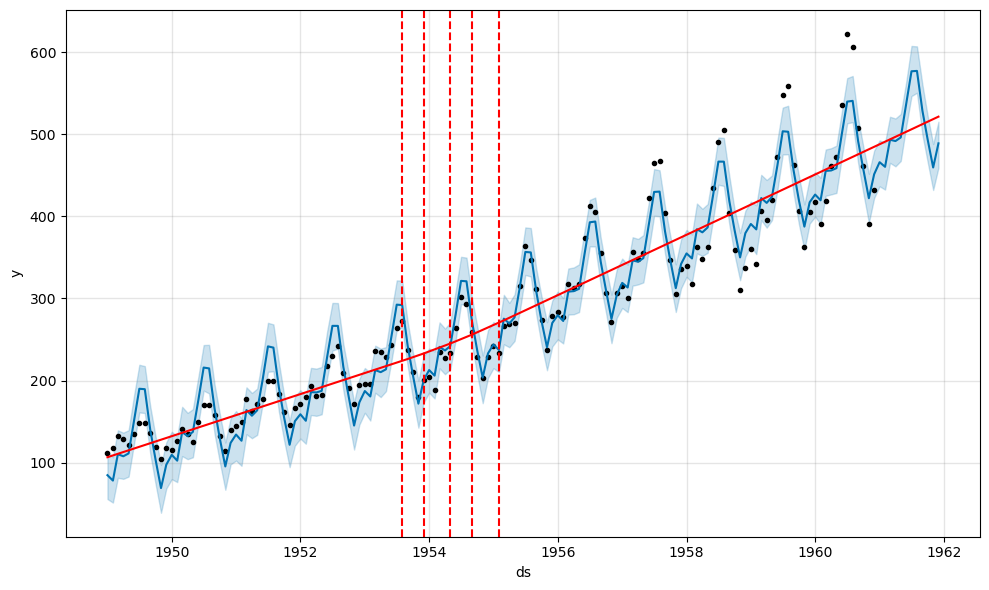

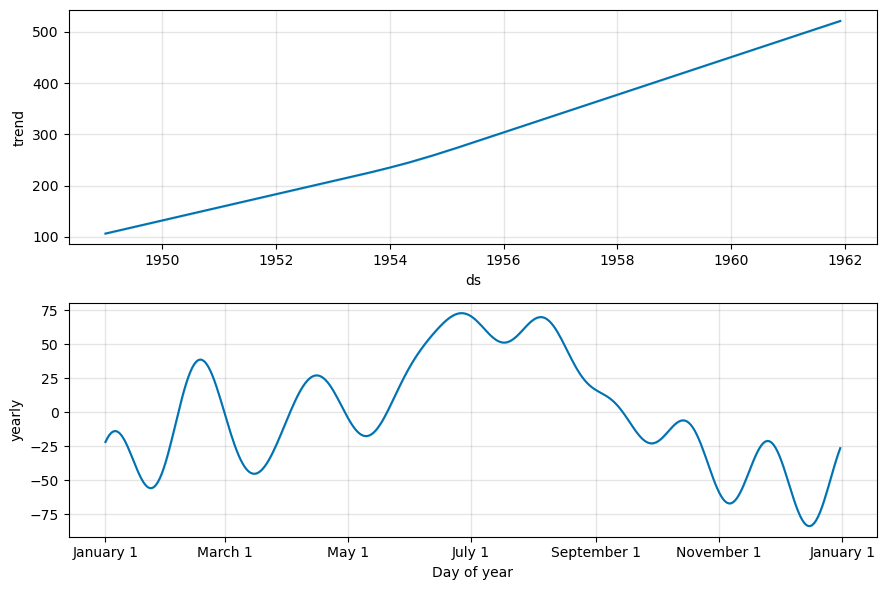

In [14]:
m2 = Prophet()

forecast_m2 = m2.fit(df).predict(future)
fig = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast_m2)

fig = m2.plot_components(forecast_m2)

## m3: Prophet tuned

12:14:39 - cmdstanpy - INFO - Chain [1] start processing
12:14:39 - cmdstanpy - INFO - Chain [1] done processing


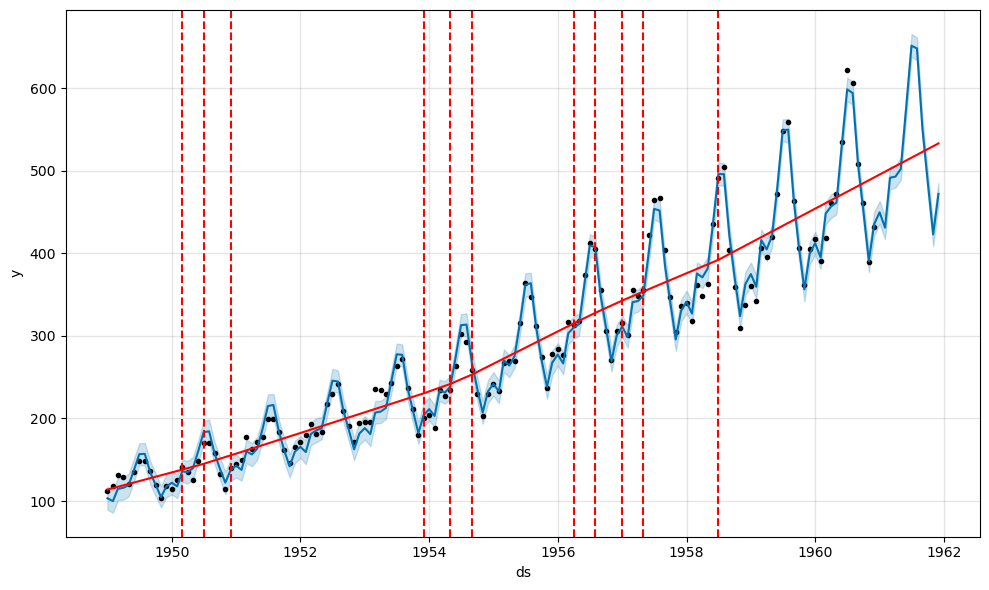

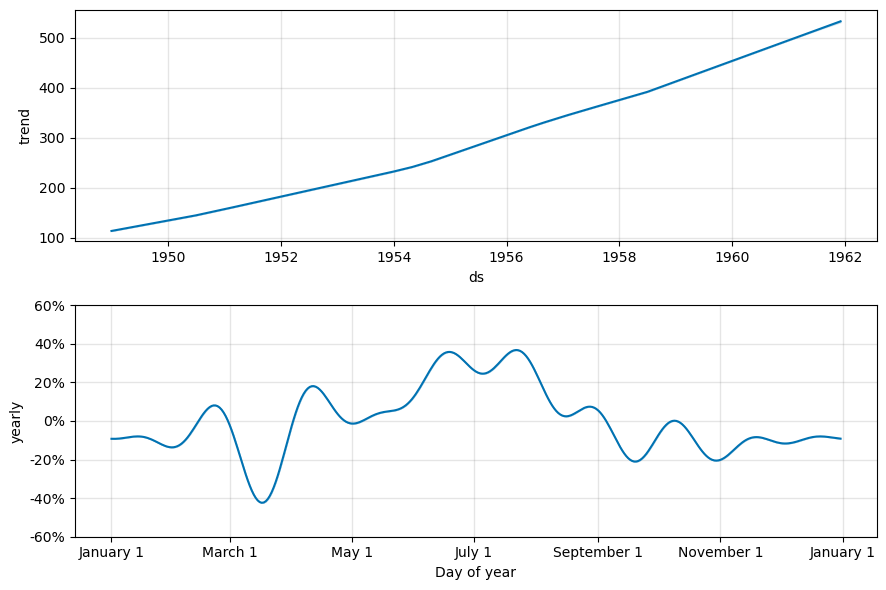

In [15]:
m3 = Prophet(
    changepoint_prior_scale=0.05,
    changepoint_range=0.8,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10
)

forecast_m3 = m3.fit(df).predict(future)
fig3 = m3.plot(forecast_m3)
a = add_changepoints_to_plot(fig3.gca(), m3, forecast_m3)

fig3 = m3.plot_components(forecast_m3)

## m4: NeuralProphet (without AR component, equivalent to prophet tuned)

#### 📋 Mapping Details:

| **Prophet Parameter**                   | **NeuralProphet Equivalent**           | **Notes**                                                |
|----------------------------------------|----------------------------------------|----------------------------------------------------------|
| `changepoint_prior_scale=0.05`         | `trend_reg=0.05`                       | Both regularize trend changes                           |
| `changepoint_range=0.8`                | `changepoints_range=0.8`              | Same concept: where changepoints can happen             |
| `seasonality_mode='multiplicative'`    | `seasonality_mode='multiplicative'`   | Forces multiplicative modeling                          |
| `seasonality_prior_scale=10`           | `seasonality_reg=10`                  | Regularizes seasonality strength                        |
| No quantiles in Prophet by default     | `quantiles=None`                       | Prophet optimizes only point prediction                 |

In [16]:
# you can disacle logging messages unless there is an error: 
from neuralprophet import set_log_level
set_log_level("ERROR")

In [17]:
m4 = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoints_range=0.8,
    trend_reg=0.05,
    seasonality_reg=10,
    quantiles=None   # Turn OFF quantile regression for pure point forecasting
)

metrics = m4.fit(df, freq="MS")
forecast_m4 = m4.predict(future)

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
# ✅ SAFE PLOTTING WITHOUT RESAMPLER
fig4 = m4.plot(forecast_m4, plotting_backend="plotly")
fig4.show()

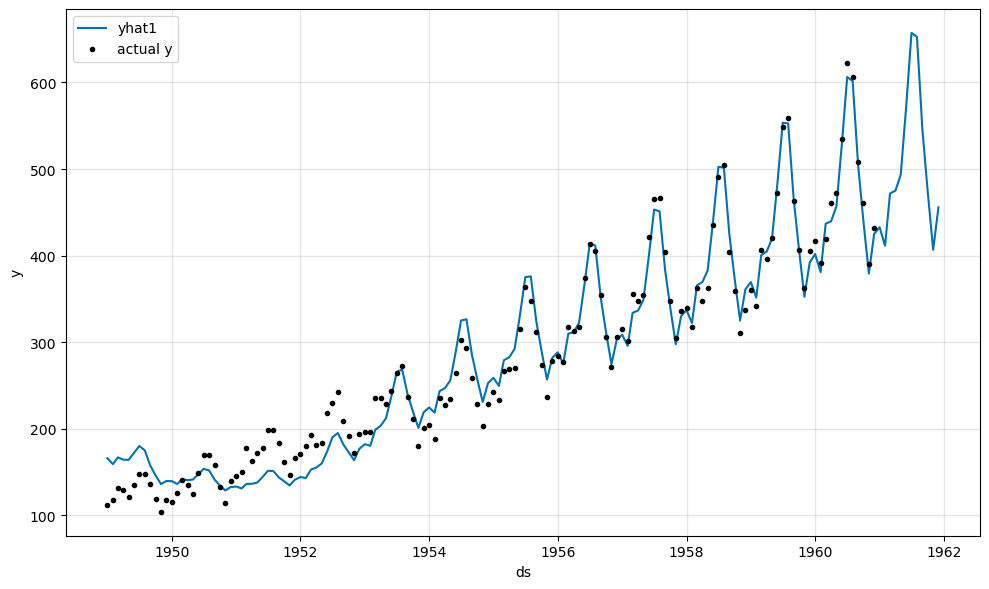

In [19]:
# ✅ SAFE PLOTTING WITHOUT RESAMPLER
fig4 = m4.plot(forecast_m4, plotting_backend="matplotlib")


In [20]:
m4.plot_parameters(plotting_backend="plotly")


In [21]:
forecast_m4.tail()

,ds,y,yhat1,trend,season_yearly
151,1961-08-01,None,652.725342,509.086151,143.639206
152,1961-09-01,None,545.396057,512.255981,33.140049
153,1961-10-01,None,473.944305,515.323608,-41.379318
154,1961-11-01,None,406.698730,518.493408,-111.794724
155,1961-12-01,None,455.738861,521.561035,-65.822159


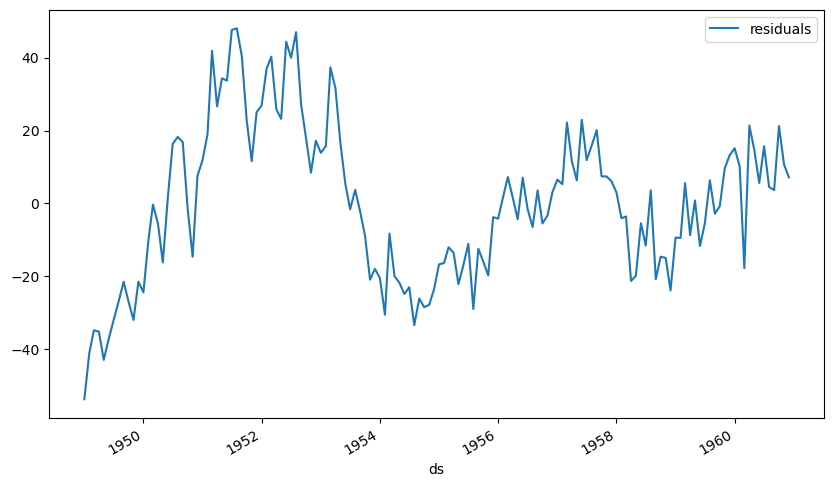

In [22]:
# plotting the residuals 
df_residuals = pd.DataFrame({"ds": df["ds"], "residuals": df["y"] - forecast_m4["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))


Clearly there is an AR component in the residuals. Let's address that! 

## m5: NeuralProphet (AR-Net)

In [23]:
# adding seasonality priors and autoregression
m5 = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoints_range=0.8,
    trend_reg=0.05,
    seasonality_reg=10,
    quantiles=None,   # Turn OFF quantile regression for pure point forecasting

    n_lags= 3, 
    # Autoregression (lagged values) with 3 lag
    ar_layers= [] ,  # linear AR with 3 lags. We could do ar_layers = [20,10] for 2 hidden layers with 20 and 10 neurons respectively.] 



    drop_missing= True, 
    # impute_missing=True
)


metrics_m5 = m5.fit(df, freq="MS")
future_m5 = m5.make_future_dataframe(df, periods=12, n_historic_predictions=True)
forecast_m5 = m5.predict(future_m5)


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\pedram\anaconda3\envs\prophet\lib\site-packages\pytorch_lightning\utilities\data.py:79: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 13. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

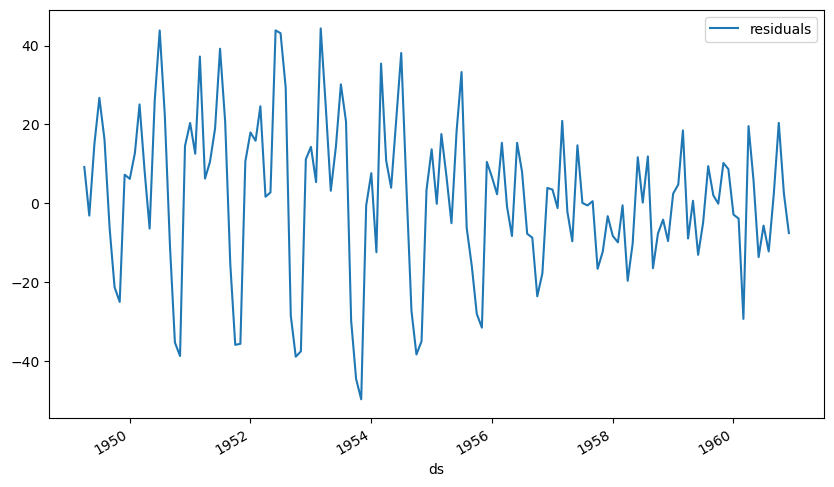

In [24]:
# plotting the residuals 
df_residuals = pd.DataFrame({"ds": df["ds"], "residuals": df["y"] - forecast_m5["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

In [25]:
fig5 = m5.plot(forecast_m5, plotting_backend="plotly")
fig5.show()

fig_components5 = m5.plot_components(forecast_m5, plotting_backend="plotly")
fig_components5.show()

In [26]:
m5.plot_parameters(plotting_backend="plotly")


## m6:NeuralProphet (AR-NET + Events)


In [27]:
# Define special events manually
df_holidays = pd.DataFrame({
    'event': 'new_year',
    # for 'ds' let's creat a list of all the new years in the dataset
    # we can use the first day and last day of the dataset to create a list of all the new years range 
    'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='YS')

})

df_holidays.head()


,event,ds
0,new_year,1949-01-01
1,new_year,1950-01-01
2,new_year,1951-01-01
3,new_year,1952-01-01
4,new_year,1953-01-01


In [28]:
# Merge event information into df
df['event_new_year'] = df['ds'].isin(df_holidays['ds']).astype(int)

df.head()

,ds,y,event_new_year
0,1949-01-01,112,1
1,1949-02-01,118,0
2,1949-03-01,132,0
3,1949-04-01,129,0
4,1949-05-01,121,0


In [29]:
# Build model with events
m6 = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoints_range=0.8,
    trend_reg=0.05,
    seasonality_reg=10,
    quantiles=None,   # Turn OFF quantile regression for pure point forecasting

    n_lags= 3, 
    # Autoregression (lagged values) with 3 lag
    drop_missing= True, 
    # impute_missing=True
)

# Add event explicitly
m6 = m6.add_events(['event_new_year'])

# we could add US calendar events too, but let's keep it simple for now
# m6 = m6.add_country_holidays("US")


# Fit and predict
metrics_m6 = m6.fit(df, freq="MS")
future_m6 = m6.make_future_dataframe(df, periods=12, n_historic_predictions=True)

# Important: future dataframe must have event columns too
future_m6['event_new_year'] = future_m6['ds'].isin(df_holidays['ds']).astype(int)

forecast_m6 = m6.predict(future_m6)

fig6 = m6.plot(forecast_m6, plotting_backend="plotly")
fig6.show()


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [30]:
m6.plot_components(forecast_m6, plotting_backend="plotly")

In [31]:
m6.plot_parameters(plotting_backend="plotly")


Be careful, our data is monthly and you shouldn't read to much into the other holidays accept the new year YYY-01-01! 

## Model Evaluations & Diagnostics

### Uncertainty Modeling 

NeuralProphet does support multiple ways to incorporate uncertainty into the forecast. 
- quantile regression: https://en.wikipedia.org/wiki/Quantile_regression
- conformal prediction 

In [32]:
confidence_level = 0.90
boundaries = round((1 - confidence_level) / 2, 3)        # 0.05
upper = round(confidence_level + boundaries, 3)          # 0.95
quantiles = [boundaries, upper]
print(quantiles)  # [0.05, 0.95]

[0.05, 0.95]


In [33]:
df.drop(columns=['event_new_year'], inplace=True)

In [34]:
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [35]:
m = NeuralProphet(quantiles=quantiles) # using the basic NeuralProphet model to see the wider confidence intervals

metrics = m.fit(df, freq="MS")


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [36]:
futures = m.make_future_dataframe(df, periods=36, n_historic_predictions=True)
forecast = m.predict(futures)
m.plot(forecast, plotting_backend="plotly")

Predicting: |          | 0/? [00:00<?, ?it/s]

While the defined coverage is guaranteed for the training date, it is not guaranteed for unseen data. More complex methods like Conformal Prediction can be used to guarantee marginal coverage for unseen data. 

conformal prediction (Naive approach): 
1. Split your time series into a training period (to fit your model) and a calibration period, 
2. then for each point in the calibration set compute its nonconformity score: $s_i = \lvert y_i - \hat{y}_i \rvert$
3. pick the quantile of those scores (ex. 90%)
4. build your prediction intervals for forecasts 

$$\mathrm{PI}_{1-\alpha}(\hat{y}_t) = \bigl[\hat{y}_t - q,\;\hat{y}_t + q\bigr]$$



In [37]:
# evaluate uncertainy on calibration set
train_df, cal_df = m.split_df(df, valid_p=0.1)
method = "naive"  # or "cqr" for a more sophisticated method, see uncertainty tutorial

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

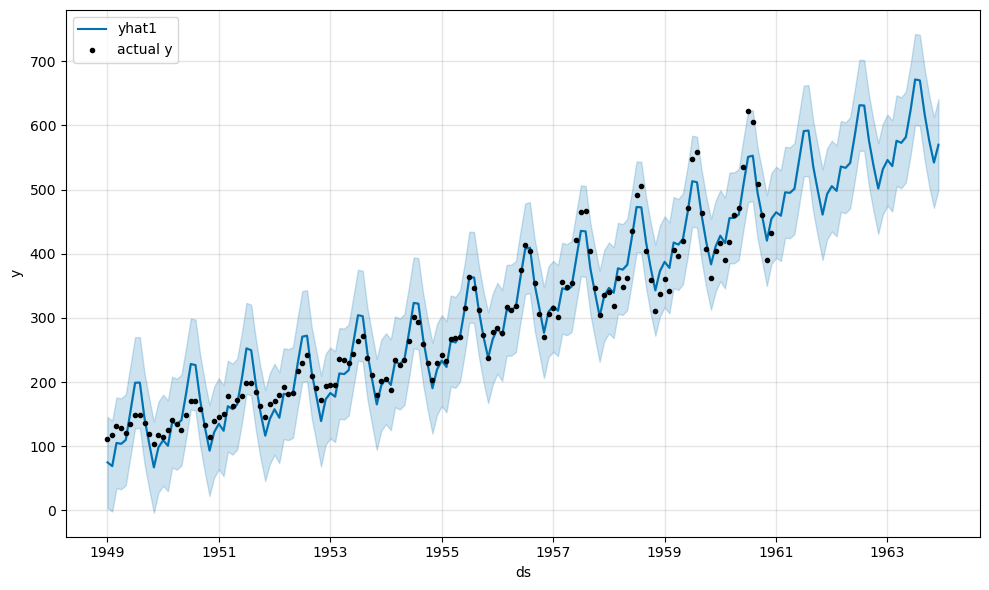

In [38]:
conformal_forecast = m.conformal_predict(futures, cal_df, alpha=0.1, method=method)
m.plot(conformal_forecast, plotting_backend="matplotlib")

the caveates of the quantile regression approach is that it requires linear model. Conformal prediction intervals are model agnostic. 

In [39]:
conformal_forecast.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly
0,1949-01-01,112,74.827393,3.983765,145.671021,103.162819,-28.335432
1,1949-02-01,118,68.997040,-1.846588,139.840668,106.116234,-37.119190
2,1949-03-01,132,105.127075,34.283447,175.970703,108.783836,-3.656759
3,1949-04-01,129,103.862442,33.018814,174.706070,111.737244,-7.874803
4,1949-05-01,121,109.906441,39.062813,180.750061,114.595390,-4.688947


### Train-Test Evaluation

In [40]:
m = NeuralProphet(seasonality_mode="multiplicative")
df_train, df_test = m.split_df(df=df, freq="MS", valid_p=0.2)


In [41]:
metrics_train = m.fit(df=df_train, freq="MS")
metrics_train 


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\pedram\anaconda3\envs\prophet\lib\site-packages\pytorch_lightning\utilities\data.py:79: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,1.472810,0.0,654.255554,834.250305,1.423893,0.0,0
1,1.350685,0.0,610.562622,776.078796,1.343883,0.0,1
2,1.252924,0.0,562.673157,721.739380,1.201391,0.0,2
3,1.169067,0.0,542.035095,688.537292,1.151084,0.0,3
4,1.090801,0.0,528.773315,652.071289,1.098544,0.0,4
...,...,...,...,...,...,...,...
225,0.000927,0.0,6.764526,8.523952,0.000907,0.0,225
226,0.000927,0.0,7.649318,9.296183,0.001109,0.0,226
227,0.000927,0.0,7.207972,8.929647,0.000994,0.0,227
228,0.000927,0.0,6.773331,8.407596,0.000914,0.0,228


In [42]:
metrics_test = m.test(df=df_test)

metrics_test

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.008327586576342583
         MAE_val            18.237695693969727
        RMSE_val            22.001108169555664
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,18.237696,22.001108,0.008328,0.0


### Cross-validation

In [43]:
METRICS = ["MAE", "RMSE"]
METRICS_VAL = ["MAE_val", "RMSE_val"]
params = {"seasonality_mode": "multiplicative"}

folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="MS", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

# fold_pct = 0.20 means that each fold will be 20% of the data
# fold_overlap_pct = 0.5 means that each fold will overlap with the next fold by 50% of the data
# This means that the first fold will be 20% of the data, the second fold will be 20% of the data starting from 10% of the data, and so on.

In [44]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS_VAL)

for df_train, df_test in folds:
    m = NeuralProphet(**params)
    m.set_plotting_backend("matplotlib")
    train = m.fit(df=df_train, freq="MS")
    test = m.test(df=df_test)

    # Get the last row (epoch) of the metrics dataframe for train and test
    last_train = train[METRICS].iloc[-1]
    last_test  = test[METRICS_VAL].iloc[-1]

    # Append the last row to the metrics dataframe for train and test
    metrics_train.loc[len(metrics_train)] = last_train
    metrics_test.loc[len(metrics_test)]   = last_test




Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\pedram\anaconda3\envs\prophet\lib\site-packages\pytorch_lightning\utilities\data.py:79: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.034189511090517044
         MAE_val             16.0891170501709
        RMSE_val            19.772356033325195
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\pedram\anaconda3\envs\prophet\lib\site-packages\pytorch_lightning\utilities\data.py:79: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08392391353845596
         MAE_val             33.27753448486328
        RMSE_val            36.090919494628906
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.030962448567152023
         MAE_val             21.06602668762207
        RMSE_val            28.476207733154297
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\pedram\anaconda3\envs\prophet\lib\site-packages\pytorch_lightning\utilities\data.py:79: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.026235222816467285
         MAE_val             27.17447853088379
        RMSE_val             31.61057472229004
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.007958969101309776
         MAE_val            17.767610549926758
        RMSE_val            21.508663177490234
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [45]:
metrics_test

,MAE_val,RMSE_val
0,16.089117,19.772356
1,33.277534,36.090919
2,21.066027,28.476208
3,27.174479,31.610575
4,17.767611,21.508663


In [46]:
metrics_test.describe()


,MAE_val,RMSE_val
count,5.000000,5.000000
mean,23.074953,27.491744
std,7.104653,6.842258
min,16.089117,19.772356
25%,17.767611,21.508663
50%,21.066027,28.476208
75%,27.174479,31.610575
max,33.277534,36.090919


You could also do train-validation-test evaluation or train-cross validation-cross test evaluation: https://neuralprophet.com/how-to-guides/feature-guides/test_and_crossvalidate.html

Exercise: 
Rerun the m1 through m6 models using timeseries simple train-test evaluation or cross validation and see which model is the winner for airline passenger data. 
Good luck! 


In [47]:
from prophet import Prophet
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Prepare data
train = df.iloc[:-12].copy()
test = df.iloc[-12:].copy()

# Define all New Year's days across full dataset
df_holidays = pd.DataFrame({
    'event': 'new_year',
    'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='YS')
})

# Create event column
#df['event_new_year'] = df['ds'].isin(df_holidays['ds']).astype(int)

# Define evaluation function
def evaluate_model_full(model, name, train_data):
    # Check if the model is Prophet (classical) or NeuralProphet
    if isinstance(model, Prophet):
        # Prophet uses periods only
        model.fit(train_data)
        future = model.make_future_dataframe(periods=12, freq='MS')
        
        forecast = model.predict(future)
        forecast = forecast[['ds', 'yhat']].dropna()

        # yhat column for Prophet
        y_pred = forecast['yhat'].values[-12:]

    elif isinstance(model, NeuralProphet):
        # NeuralProphet uses freq + n_historic_predictions
        model.fit(train_data, freq="MS")
        future = model.make_future_dataframe(train_data, periods=12, n_historic_predictions=False)

        forecast = model.predict(future)
        forecast = forecast.dropna(subset=["yhat1"])

        # yhat1 column for NeuralProphet
        y_pred = forecast['yhat1'].values

    else:
        raise ValueError("Unsupported model type. Must be Prophet or NeuralProphet.")

    # Align y_true and y_pred
    y_true = test['y'].values[-len(y_pred):]

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)

    return [name, mae, mape, mse]

# -----------------------------------
# Define models
# -----------------------------------

# M1 - Neural prophet with default settings
m1_eval = NeuralProphet()

# M2 - prophet with default setting
m2_eval = Prophet()

# M3 
m3_eval = Prophet(
    changepoint_prior_scale=0.05,
    changepoint_range=0.8,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10
)

# M4
m4_eval = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoints_range=0.8,
    trend_reg=0.05,
    seasonality_reg=10,
    quantiles=None 
)

# M5
m5_eval = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoints_range=0.8,
    trend_reg=0.05,
    seasonality_reg=10,
    quantiles=None,   # Turn OFF quantile regression for pure point forecasting

    n_lags= 3, 
    # Autoregression (lagged values) with 3 lag
    drop_missing= True, 
    # impute_missing=True
)

# M6
m6_eval = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoints_range=0.8,
    trend_reg=0.05,
    seasonality_reg=10,
    quantiles=None,   # Turn OFF quantile regression for pure point forecasting

    n_lags= 3, 
    # Autoregression (lagged values) with 3 lag
    drop_missing= True, 
    # impute_missing=True
)
m6_eval = m6_eval.add_events(["new_year"])

# Special train/future for M4
train_m6 = train.copy()
train_m6['new_year'] = train_m6['ds'].isin(df_holidays['ds']).astype(int)
future_m6 = m6_eval.make_future_dataframe(train_m6, periods=12, n_historic_predictions=True)
future_m6['new_year'] = future_m6['ds'].isin(df_holidays['ds']).astype(int)




In [48]:

# -----------------------------------
# Evaluate all models
# -----------------------------------

results = []


# M1
results.append(evaluate_model_full(m1_eval, "M1 - np base", train))

#M2
results.append(evaluate_model_full(m2_eval, "M2 - p base", train))

# M3
results.append(evaluate_model_full(m3_eval, "M3 - p tuned", train))

# M4
results.append(evaluate_model_full(m4_eval, "M4 - np tuned no AR", train))

# M5
results.append(evaluate_model_full(m5_eval, "M5 - np AR-NET", train))

# M6
results.append(evaluate_model_full(m6_eval, "M6 - np AR-NET events", train_m6))



# -----------------------------------
# Final Metrics Table
# -----------------------------------

metrics_table = pd.DataFrame(results, columns=["Model", "MAE", "MAPE (%)", "MSE"])
(metrics_table)


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

12:18:05 - cmdstanpy - INFO - Chain [1] start processing
12:18:05 - cmdstanpy - INFO - Chain [1] done processing
12:18:05 - cmdstanpy - INFO - Chain [1] start processing
12:18:05 - cmdstanpy - INFO - Chain [1] done processing


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\pedram\anaconda3\envs\prophet\lib\site-packages\pytorch_lightning\utilities\data.py:79: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

,Model,MAE,MAPE (%),MSE
0,M1 - np base,30.957697,6.003392,1587.253418
1,M2 - p base,33.443325,6.614641,1856.171274
2,M3 - p tuned,21.897699,4.441288,666.811446
3,M4 - np tuned no AR,14.736590,3.269936,323.805023
4,M5 - np AR-NET,4.988770,1.154808,24.887821
5,M6 - np AR-NET events,1.508423,0.349172,2.275340


In [49]:
metrics_table

,Model,MAE,MAPE (%),MSE
0,M1 - np base,30.957697,6.003392,1587.253418
1,M2 - p base,33.443325,6.614641,1856.171274
2,M3 - p tuned,21.897699,4.441288,666.811446
3,M4 - np tuned no AR,14.736590,3.269936,323.805023
4,M5 - np AR-NET,4.988770,1.154808,24.887821
5,M6 - np AR-NET events,1.508423,0.349172,2.275340


* Default Prophet and NeuralProphet models are okay but not optimal.

* Tuning changepoints and seasonality improves both Prophet and NeuralProphet models.

* Adding autoregression (AR-Net) helps NeuralProphet capture short-term dependencies.

* Including external events (e.g., New Year) boosts NeuralProphet forecasting.

* NeuralProphet models with AR + events (M6) achieved the best accuracy.

* Tuning + domain knowledge = best forecasting performance.

Done